In [37]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import os
import seaborn as sns

pd.options.mode.chained_assignment = None

In [38]:
# unzipping survey tables

# specifying location of .zip and extraction location
sur_B_path="/home/rthoms/ocean_dep/sur_B/raw_data/Sur_B_06062023.zip"
sur_B_raw="/home/rthoms/ocean_dep/sur_B/raw_data/sur_B_raw"

# loading the .zip and creating a zip object
with ZipFile(sur_B_path, 'r') as zObject:

	# Extracting all the members of the zip
	# into a the specified location.
	zObject.extractall(
		path=sur_B_raw)

# specifiy location of raw data
# main survey table
ss_raw = os.path.join(sur_B_raw, "Form_4_0.csv")
df_ss = pd.read_csv(ss_raw)

# practice table
prac_raw = os.path.join(sur_B_raw, "fish_pract_table_1.csv")
df_prac = pd.read_csv(prac_raw)

# capture resource table
cap_raw = os.path.join(sur_B_raw, "capture_resource_table_2.csv")
df_cap = pd.read_csv(cap_raw)

# income resource table
inc_raw = os.path.join(sur_B_raw, "other_income_table_3.csv")
df_inc = pd.read_csv(inc_raw)

# nutrition resource table
nut_raw = os.path.join(sur_B_raw, "nutrition_sources_table_4.csv")
df_nut = pd.read_csv(nut_raw)

# tradiion resource table
trad_raw = os.path.join(sur_B_raw, "tradition_resource_table_5.csv")
df_trad = pd.read_csv(trad_raw)

# social resource table
soc_raw = os.path.join(sur_B_raw, "social_resources_table_6.csv")
df_soc = pd.read_csv(soc_raw)

# identity resource table
iden_raw = os.path.join(sur_B_raw, "personal_identity_table_7.csv")
df_iden = pd.read_csv(iden_raw)

# species table
species = pd.read_csv("/home/rthoms/ocean_dep/sur_B/species.csv")
species.rename(columns={'resource_id':'focal_resource'}, inplace=True)


# Drop all columns beginning with an underscore
dfs = [df_ss,df_prac,df_cap, df_inc,df_nut,df_trad,df_soc,df_iden]
for df in dfs:
    df.drop(columns=[col for col in df if col.startswith('_')], inplace=True) 
    
units_cnv_path ="/home/rthoms/ocean_dep/sur_B/units.csv"
units_cnv = pd.read_csv(units_cnv_path)
species 

,focal_resource,Gitonga (s),Gitonga (p),Portuguese,Scientific,Family,phylum,category,focal,seagrass,Fishing Vulnerability,Climate Vulnerability
0,1,hili,mihili,pescadinha,Sillago sihama,Sillaginidae,bony fish,fish,1,0.0,24.0,43.0
1,2,livbionho,mavbionho,Melanúria comum,Gerres oyena,Gerreidae,bony fish,fish,1,NaN,NaN,NaN
2,3,salani,NaN,Melanúria timoneira,Gerres longirostris,Gerreidae,bony fish,fish,1,NaN,NaN,NaN
3,4,pata,dzipata,peixe zebras,Teraponidae,Teraponidae,bony fish,fish,1,NaN,NaN,NaN
4,5,pata,dzipata,peixe zebras,Teraponidae,Teraponidae,bony fish,fish,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
70,78,togoma,dzitogoma,Caracóis,Volema paradisiaca,Melongenidae,mollusc,gastropod,1,NaN,NaN,NaN
71,79,guikhokoroma,sikhokoroma,NaN,Pleuroploca trapezium,Fasciolarriidae,mollusc,gastropod,0,NaN,NaN,NaN
72,80,solo,dzisolo,NaN,Cypraeidae,Cypraeidae,mollusc,gastropod,0,NaN,NaN,NaN
73,84,guiccucuani,siccucuani,NaN,Gafrarium divaricatum,Veneridae,mollusc,bivalve,0,NaN,NaN,NaN


In [39]:
# Create parent table of demographic and practice data

# Isolate columns from the demographic table
df_ss_sub=df_ss.loc[:, ['GlobalID','id','ccp','gender']]

# Rename GlobalID column to match with children IDs
df_ss_sub.rename(columns={'GlobalID':'ParentGlobalID'}, inplace=True)

# Isolate columns from practice table
df_prac_sub=df_prac.loc[:, ['ParentGlobalID','fish_pract','owner','catch_proportion']]

# Join demographic table and practice table
# note that fishers who use two gears will be represented twice 
df_ss_prac = pd.merge(df_ss_sub,df_prac_sub,on='ParentGlobalID', how='outer')




# Capture

In [40]:
# Merge with demo data
# Change fishing practice column name to match the gear used to catch that item
# This will avoid duplicates

# Rename the gear column to merge with capture table
df_ss_prac_ed = df_ss_prac.rename(columns={'fish_pract':'gear_used_hot'})
# Merge demo/practice table with capture table
df_ss_cap = pd.merge(df_ss_prac_ed,df_cap,on=['ParentGlobalID','gear_used_hot'], how='outer')

# create a dictionary of units and their conversions to kgs
unit_dict= pd.Series(units_cnv.weight_kg.values,index=units_cnv.unit).to_dict()

# merge with species data
df_ss_cap= df_ss_cap[df_ss_cap['focal_resource'] != 'NR']
df_ss_cap= df_ss_cap[df_ss_cap['focal_resource'].notna()]
df_ss_cap = pd.merge(df_ss_cap,species,on='focal_resource', how='left')

# drop non_focal resources
df_ss_cap=df_ss_cap[df_ss_cap['focal']!= 0]


# Note there are several NaN values that need to be cleaned up
df_ss_cap_dup = df_ss_cap[df_ss_cap.duplicated(subset=['ParentGlobalID','focal_resource'], keep=False)]

# There are also some values for 'gear_used_hot' that are a list --> needs to be delt with
df_ss_cap

,ParentGlobalID,id,ccp,gender,gear_used_hot,owner,catch_proportion,ObjectID,GlobalID,focal_resource,...,Gitonga (p),Portuguese,Scientific,Family,phylum,category,focal,seagrass,Fishing Vulnerability,Climate Vulnerability
0,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,7.0,5cf789e2-326d-4f7f-b604-4eed34dc194b,50,...,dzindrolo,Caranguejo,Portunus pelagicus,Portunidae,crustacean,crabs,1.0,NaN,NaN,NaN
1,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,na,1.00,17.0,8428e640-0211-43dc-8b36-e01d7d672911,60,...,matewo,NaN,Pinna muricata,Pinnidae,mollusc,bivalve,1.0,NaN,NaN,NaN
2,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,na,1.00,18.0,bc568a6b-1ab4-46d1-ae1d-891489c1702b,61,...,mavalo,ostra,Margaritidae,Margaritidae,mollusc,bivalve,1.0,NaN,NaN,NaN
3,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,27.0,d342261d-0a99-4fb2-8536-9e739053b601,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,28.0,22ab401a-38f8-4ba3-ad79-9cd4961e8e8c,03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,f5769b1d-ab41-4ec3-9364-13194af91f08,NaN,NaN,NaN,NaN,NaN,NaN,395.0,75f50718-6d44-4166-9944-49ebf962c486,02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,f5769b1d-ab41-4ec3-9364-13194af91f08,NaN,NaN,NaN,NaN,NaN,NaN,397.0,9ff068e0-6695-4cf3-b007-48d856cf4f06,06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,66a27df6-476b-4917-8244-24e557b34ede,NaN,NaN,NaN,NaN,NaN,NaN,407.0,d9bedf48-cf32-43ca-90ec-2a518cc3f08c,02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,66a27df6-476b-4917-8244-24e557b34ede,NaN,NaN,NaN,NaN,NaN,NaN,408.0,e316f6a6-99c9-48d1-b743-bbdec6ff810e,04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# List columns
df_ss_cap.columns

Index(['ParentGlobalID', 'id', 'ccp', 'gender', 'gear_used_hot', 'owner',
       'catch_proportion', 'ObjectID', 'GlobalID', 'focal_resource',
       'prop_cap_hot_raw', 'prop_cap_hot', 'days_hot', 'quant_cap_hot',
       'cap_units_hot_label', 'cap_units_hot', ' cap_units_hot_other',
       'sold_hot_raw', 'sold_hot', 'eaten_hot_raw', 'eaten_hot',
       'traded_hot_raw', 'traded_hot', 'offered_hot_raw', 'offered_hot',
       'sum_use_hot', 'sale_price_hot', 'sale_unit_hot', 'sale_unit_hot_other',
       'prop_cap_cold_raw', 'prop_cap_cold', 'gear_used_cold', 'days_cold',
       'quant_cap_cold', 'cap_units_cold', 'cap_units_cold_label',
       'cap_units_cold_other', 'sold_cold_raw', 'sold_cold', 'eaten_cold_raw',
       'eaten_cold', 'traded_cold_raw', 'traded_cold', 'offered_cold_raw',
       'offered_cold', 'sum_use_cold', 'sale_price_cold', 'sale_unit_cold',
       'sale_unit_cold_other', 'quant_traded', 'unit_traded',
       'product_recieved', 'quant_recieved', 'unit_recieved',

In [42]:
# Define funtions for analyzing the capture data
def fill_other(col, col_other):
    if col == "other":
        return col_other
    else:
        return col

def cap_p_mo_p_gear(days, units, quant):
    days_p_mo = days*2
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap_p_mo = days_p_mo* quant* units_cv
    else: 
        cap_p_mo = None
    return cap_p_mo


def cap_p_day(units, quant):
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap_p_day = quant* units_cv
    else: 
        cap_p_day = None
    return cap_p_day

def cap_p_mo(cap_p_mo_p_gear, prop):
    cap_p_mo = cap_p_mo_p_gear * prop
    return cap_p_mo


In [43]:
# Apply functions
df_ss_cap['cap_units_hot_final']= df_ss_cap.apply(lambda row: fill_other(row['cap_units_hot'],row[' cap_units_hot_other']), axis=1 )
df_ss_cap['cap_hot_p_mo_p_gear'] = df_ss_cap.apply(lambda row: cap_p_mo_p_gear(row['days_hot'], row['cap_units_hot_final'],  row['quant_cap_hot']), axis=1)
df_ss_cap['cap_hot_p_day_p_gear'] = df_ss_cap.apply(lambda row: cap_p_day(row['cap_units_hot_final'],  row['quant_cap_hot']), axis=1)

In [44]:
# Fill in zeros 
# We want any resources not recorded for capture to have zero values. Currently these resources are not in the data set

'''
# Create an empty dataset with all ID, resource pairs
parentID_col_vals = list(df_ss_cap['ParentGlobalID'].unique())
resource_col_vals = list(df_ss_cap['focal_resource'].unique())
levels = [parentID_col_vals, resource_col_vals]
new_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','focal_resource'])
df_0 = pd.DataFrame(index=new_index, columns=['prop_cap_hot','prop_cap_cold']).fillna(0) 

# drop any pairs that are already in the dataframe
df_ss_cap_index = df_ss_cap.set_index(['ParentGlobalID','focal_resource'])
index_list= (list(df_ss_cap_index.index))
df_0.drop(index_list, axis=0, inplace=True)
df_0.reset_index(inplace=True)
df_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]

# stack the two DataFrames
df_ss_cap_prop = pd.concat([df_ss_cap, df_0], ignore_index=True, axis=0)
len(df_ss_cap_prop)
'''


"\n# Create an empty dataset with all ID, resource pairs\nparentID_col_vals = list(df_ss_cap['ParentGlobalID'].unique())\nresource_col_vals = list(df_ss_cap['focal_resource'].unique())\nlevels = [parentID_col_vals, resource_col_vals]\nnew_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','focal_resource'])\ndf_0 = pd.DataFrame(index=new_index, columns=['prop_cap_hot','prop_cap_cold']).fillna(0) \n\n# drop any pairs that are already in the dataframe\ndf_ss_cap_index = df_ss_cap.set_index(['ParentGlobalID','focal_resource'])\nindex_list= (list(df_ss_cap_index.index))\ndf_0.drop(index_list, axis=0, inplace=True)\ndf_0.reset_index(inplace=True)\ndf_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]\n\n# stack the two DataFrames\ndf_ss_cap_prop = pd.concat([df_ss_cap, df_0], ignore_index=True, axis=0)\nlen(df_ss_cap_prop)\n"

In [45]:
#MEAN PROPORTION OF CATCH BY RESOURCE

# By gender
# df_ss_cap_sub= df_ss_cap_prop[df_ss_cap['gender'] == 'f']
#df_ss_cap_sub= df_ss_cap_prop[df_ss_cap['fish_pract'] == 'glean']
#df_ss_cap_sub= df_ss_cap_prop[df_ss_cap['ccp'] == 'ilha']
#df_ss_cap_sub= df_ss_cap_prop[(df_ss_cap['fish_pract'] == 'glean') & (df_ss_cap_prop['ccp'] == 'ilha')]

#Total
df_ss_cap_sub = df_ss_cap
df_ss_cap_sub

,ParentGlobalID,id,ccp,gender,gear_used_hot,owner,catch_proportion,ObjectID,GlobalID,focal_resource,...,Family,phylum,category,focal,seagrass,Fishing Vulnerability,Climate Vulnerability,cap_units_hot_final,cap_hot_p_mo_p_gear,cap_hot_p_day_p_gear
0,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,7.0,5cf789e2-326d-4f7f-b604-4eed34dc194b,50,...,Portunidae,crustacean,crabs,1.0,NaN,NaN,NaN,kgs,8.0,1.000
1,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,na,1.00,17.0,8428e640-0211-43dc-8b36-e01d7d672911,60,...,Pinnidae,mollusc,bivalve,1.0,NaN,NaN,NaN,cups,5.6,0.700
2,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,na,1.00,18.0,bc568a6b-1ab4-46d1-ae1d-891489c1702b,61,...,Margaritidae,mollusc,bivalve,1.0,NaN,NaN,NaN,cups,7.0,0.875
3,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,27.0,d342261d-0a99-4fb2-8536-9e739053b601,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basin,216.0,36.000
4,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,28.0,22ab401a-38f8-4ba3-ad79-9cd4961e8e8c,03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basin,168.0,12.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,f5769b1d-ab41-4ec3-9364-13194af91f08,NaN,NaN,NaN,NaN,NaN,NaN,395.0,75f50718-6d44-4166-9944-49ebf962c486,02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,f5769b1d-ab41-4ec3-9364-13194af91f08,NaN,NaN,NaN,NaN,NaN,NaN,397.0,9ff068e0-6695-4cf3-b007-48d856cf4f06,06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,66a27df6-476b-4917-8244-24e557b34ede,NaN,NaN,NaN,NaN,NaN,NaN,407.0,d9bedf48-cf32-43ca-90ec-2a518cc3f08c,02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,66a27df6-476b-4917-8244-24e557b34ede,NaN,NaN,NaN,NaN,NaN,NaN,408.0,e316f6a6-99c9-48d1-b743-bbdec6ff810e,04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Number of responses')

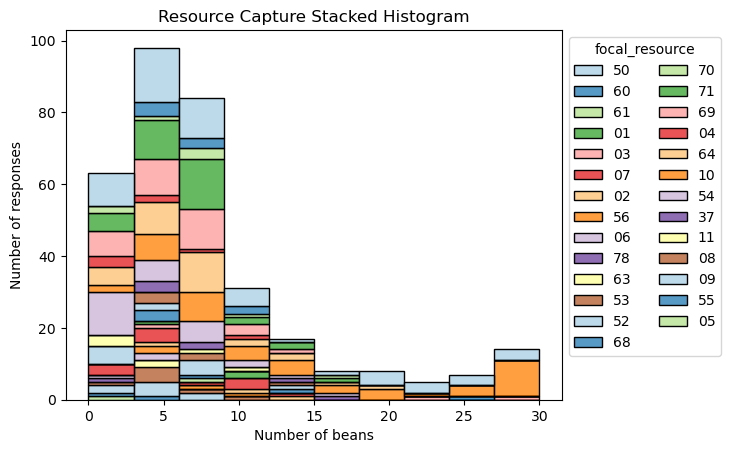

In [48]:
# Aggregate data based on resource captured. Create a column for the meam value
df_ss_cap_sub.prop_cap_hot_raw = df_ss_cap_sub.prop_cap_hot_raw.round()

ax = sns.histplot(data=df_ss_cap_sub, stat="count",multiple="stack", x="prop_cap_hot_raw", kde=False, palette = "Paired", hue="focal_resource", element="bars",legend=True, binwidth=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), ncol=2)
ax.set_title("Resource Capture Stacked Histogram")
ax.set_xlabel("Number of beans")
ax.set_ylabel("Number of responses")

In [47]:

sns.histplot(num_beans_hot, x="prop_cap_hot_raw", binwidth=30)

NameError: name 'num_beans_hot' is not defined

Text(0, 0.5, 'Total number of beans allocated by resource')

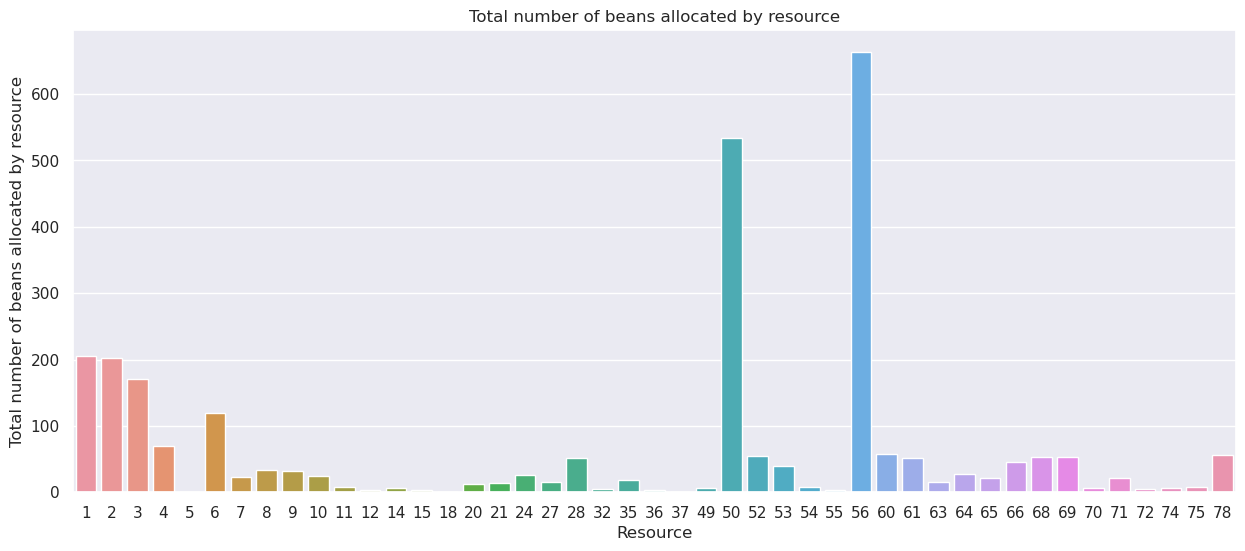

In [ ]:
sns.barplot(num_beans_hot, x='focal_resource', y= 'prop_cap_hot_raw')
# set title
plt.title('Total number of beans allocated by resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Total number of beans allocated by resource')

Text(0, 0.5, 'Daily catch (kg)')

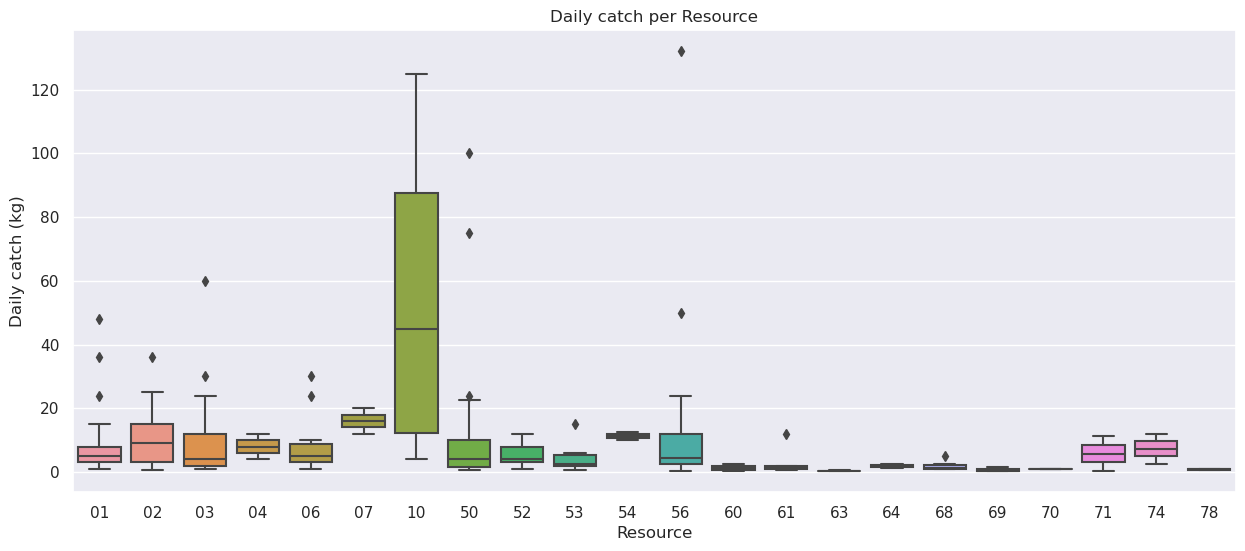

In [ ]:
# DAILY CATCH PER RESOURCE
df_viz= df_ss_cap.pivot_table(index=['ObjectID'], columns='focal_resource', values='cap_hot_p_day_p_gear')
#consider removing 10
#df_viz= df_ss_cap[df_ss_cap['focal_resource'] != '10'].pivot_table(index=['ObjectID'], columns='focal_resource', values='cap_hot_p_day_p_gear')


df_viz.to_csv("temp.csv")
#plot
sns.set(rc={"figure.figsize":(15, 6)})
sns.boxplot(data=df_viz)
# set title
plt.title('Daily catch per Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Daily catch (kg)')

Text(0, 0.5, 'Monthly catch (kg)')

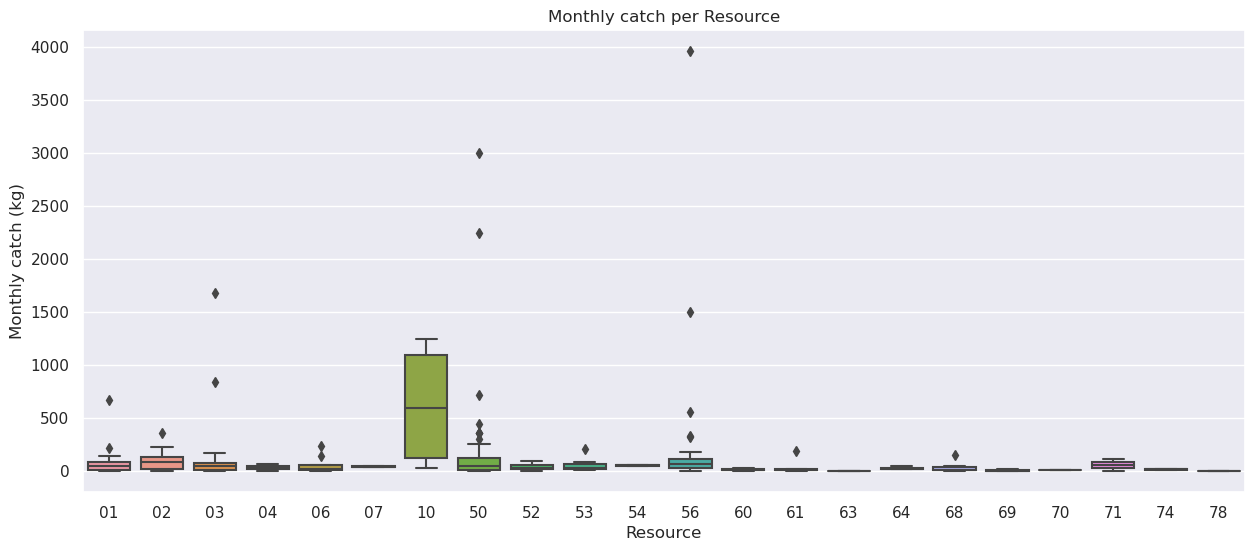

In [ ]:
# MONTHLY CATCH PER RESOURCE

df_viz= df_ss_cap.pivot_table(index=['ObjectID'], columns='focal_resource', values='cap_hot_p_mo_p_gear')
#consider removing 10
#df_viz= df_ss_cap[df_ss_cap['focal_resource'] != '10'].pivot_table(index=['ObjectID'], columns='focal_resource', values='cap_hot_p_mo_p_gear')


df_viz.to_csv("temp.csv")
#plot
sns.set(rc={"figure.figsize":(15, 6)})
sns.boxplot(data=df_viz)
# set title
plt.title('Monthly catch per Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Monthly catch (kg)')


In [ ]:
col_to_keep = ['ccp','practice', 'catch_proportion','cap_units_hot',' cap_units_hot_other','cap_units_hot_final','days_hot','cap_units_hot_final','quant_cap_hot','cap__hot_p_mo_p_gear', 'cap__hot_p_mo']

temp = df_ss_cap[df_ss_cap.columns.intersection(col_to_keep)]
temp.to_csv('temp.csv')

# Nutrition

In [ ]:
parentID_col_vals = list(df_nut['ParentGlobalID'].unique())
resource_col_vals = list(df_nut['nutrition_source'].unique())
levels = [parentID_col_vals, resource_col_vals]
new_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','nutrition_source'])
df_0 = pd.DataFrame(index=new_index, columns=['nutrition_prop_hot','nutrition_prop_cold']).fillna(0) 

# drop any pairs that are already in the dataframe
df_nut_index = df_nut.set_index(['ParentGlobalID','nutrition_source'])
index_list= (list(df_nut_index.index))
df_0.drop(index_list, axis=0, inplace=True)
df_0.reset_index(inplace=True)
df_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]

# stack the two DataFrames
df_nut_prop = pd.concat([df_nut, df_0], ignore_index=True, axis=0)

# Merge with capture data
df_ss_nut = pd.merge(df_ss_prac,df_nut_prop,on='ParentGlobalID', how='outer')


,ParentGlobalID,id,ccp,gender,gear_used_hot,owner,catch_proportion,ObjectID,GlobalID,nutrition_source,nutrition_prop_hot_raw,nutrition_prop_hot,nutrition_prop_cold_raw,nutrition_prop_cold,CreationDate,Creator,EditDate,Editor
0,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,8,356d97d1-fd26-43aa-820e-47af9d5877b6,01,2.0,0.066667,2.0,0.066667,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri
1,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,9,39b5fafa-e6ab-4102-9ce8-7a4d63e5350c,02,2.0,0.066667,2.0,0.066667,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri
2,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,10,af2c21d6-f5de-4dfe-ae45-7aa6e1292502,07,2.0,0.066667,2.0,0.066667,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri
3,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,11,7dd90b1c-1b00-40c6-a856-0769d36666ac,50,10.0,0.333333,10.0,0.333333,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri
4,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,na,1.00,12,d9729ecd-82ee-4d4e-8d5d-219906ab7257,56,2.0,0.066667,2.0,0.066667,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,66a27df6-476b-4917-8244-24e557b34ede,19022023ILHB07,ilha,m,gill_net,worker,0.33,4304,NaN,68,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
4941,66a27df6-476b-4917-8244-24e557b34ede,19022023ILHB07,ilha,m,gill_net,worker,0.33,4305,NaN,15,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
4942,66a27df6-476b-4917-8244-24e557b34ede,19022023ILHB07,ilha,m,gill_net,worker,0.33,4306,NaN,69,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
4943,66a27df6-476b-4917-8244-24e557b34ede,19022023ILHB07,ilha,m,gill_net,worker,0.33,4307,NaN,10,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Mean Household Consumption')

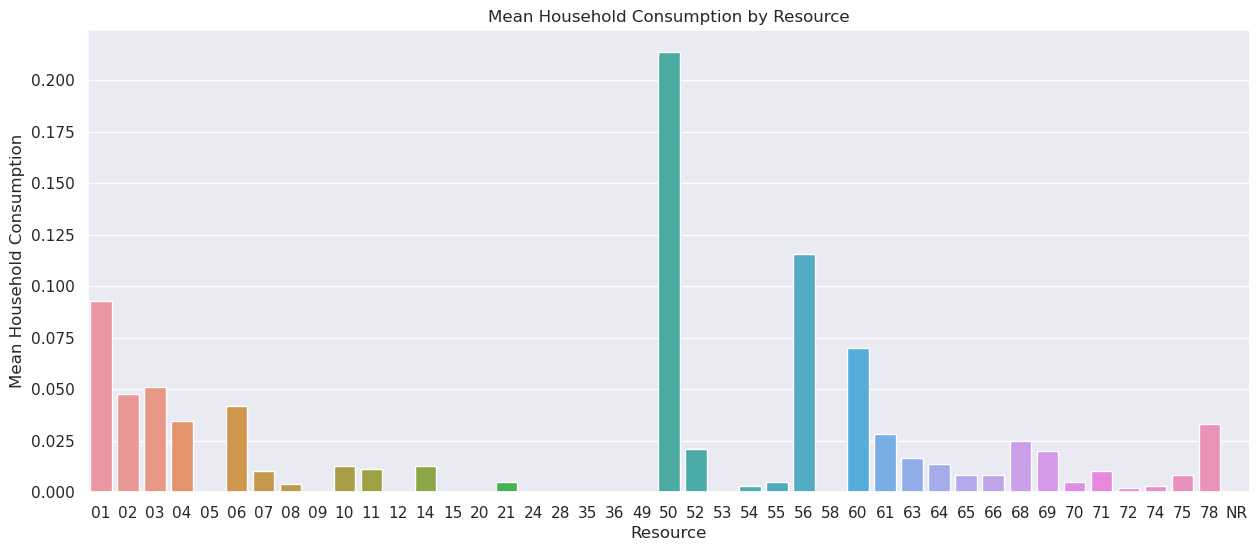

In [ ]:
# HOUSEHOLD CONSUMPTION BY RESOURCE

# By gender
#df_ss_nut_sub= df_ss_nut[df_ss_nut['gender'] == 'm']
# By practice
df_ss_nut_sub= df_ss_nut[df_ss_nut['gear_used_hot'] == 'glean']
# By ccp
#df_ss_nut_sub= df_ss_nut[df_ss_nut['ccp'] == 'ilha']
# By ccp and practice
#df_ss_nut_sub= df_ss_nut[(df_ss_nut['fish_pract'] == 'glean') & (df_ss_nut['ccp'] == 'ilha')]
#Total
#df_ss_nut_sub = df_ss_nut

df_ss_nut_sum= df_ss_nut_sub.groupby(['nutrition_source']).agg({'nutrition_prop_hot': 'mean'}).reset_index()

sns.barplot(df_ss_nut_sum, x='nutrition_source', y= 'nutrition_prop_hot')
# set title
plt.title('Mean Household Consumption by Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Mean Household Consumption')

# Tradition

In [ ]:
parentID_col_vals = list(df_trad['ParentGlobalID'].unique())
resource_col_vals = list(df_trad['trad_resource'].unique())
levels = [parentID_col_vals, resource_col_vals]
new_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','trad_resource'])
df_0 = pd.DataFrame(index=new_index, columns=['tradition']).fillna(0) 

# drop any pairs that are already in the dataframe
df_trad_index = df_trad.set_index(['ParentGlobalID','trad_resource'])
index_list= (list(df_trad_index.index))
df_0.drop(index_list, axis=0, inplace=True)
df_0.reset_index(inplace=True)
df_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]

# stack the two DataFrames
df_trad_prop = pd.concat([df_trad, df_0], ignore_index=True, axis=0)

# Merge with capture data
df_ss_trad = pd.merge(df_ss_prac,df_trad_prop,on='ParentGlobalID', how='outer')


Index(['ParentGlobalID', 'id', 'ccp', 'gender', 'gear_used_hot', 'owner',
       'catch_proportion', 'ObjectID', 'GlobalID', 'trad_resource',
       'tradition_raw', 'tradition', 'CreationDate', 'Creator', 'EditDate',
       'Editor'],
      dtype='object')

Text(0, 0.5, 'Proportion of Contribution to Tradition by number of fishers reporting')

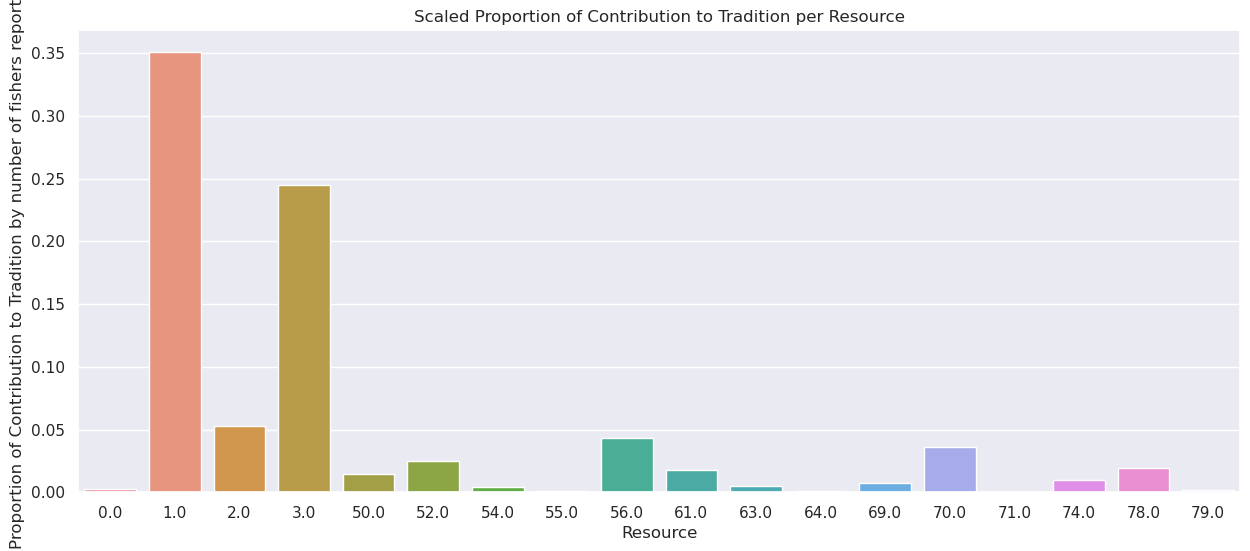

In [ ]:
# CONTRIBUTION TO TRADITION BY RESOURCE

# By gender
#df_ss_trad_sub= df_ss_trad[df_ss_trad['gender'] == 'm']
# By practice
#df_ss_trad_sub= df_ss_trad[df_ss_trad['fish_pract'] == 'glean']
# By ccp
#df_ss_trad_sub= df_ss_trad[df_ss_trad['ccp'] == 'ilha']
# By ccp and practice
#df_ss_trad_sub= df_ss_trad[(df_ss_trad['fish_pract'] == 'glean') & (df_ss_trad['ccp'] == 'ilha')]
#Total
df_ss_trad_sub = df_ss_trad

df_ss_trad_sum= df_ss_trad_sub.groupby(['trad_resource']).agg({'tradition': 'mean'}).reset_index()

sns.barplot(df_ss_trad_sum, x='trad_resource', y= 'tradition')
# set title
plt.title('Mean Proportion of Contribution to Tradition per Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Mean Proportion Contribution to Tradition')

# Social Union

In [ ]:
parentID_col_vals = list(df_soc['ParentGlobalID'].unique())
resource_col_vals = list(df_soc['social_resource'].unique())
levels = [parentID_col_vals, resource_col_vals]
new_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','social_resource'])
df_0 = pd.DataFrame(index=new_index, columns=['social']).fillna(0) 

# drop any pairs that are already in the dataframe
df_soc_index = df_soc.set_index(['ParentGlobalID','social_resource'])
index_list= (list(df_soc_index.index))
df_0.drop(index_list, axis=0, inplace=True)
df_0.reset_index(inplace=True)
df_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]

# stack the two DataFrames
df_soc_prop = pd.concat([df_soc, df_0], ignore_index=True, axis=0)


# Merge with capture data
df_ss_soc = pd.merge(df_ss_prac,df_soc_prop,on='ParentGlobalID', how='outer')

df_ss_soc.columns

Index(['ParentGlobalID', 'id', 'ccp', 'gender', 'gear_used_hot', 'owner',
       'catch_proportion', 'ObjectID', 'GlobalID', 'social_resource',
       'social_raw', 'social', 'CreationDate', 'Creator', 'EditDate',
       'Editor'],
      dtype='object')

Text(0, 0.5, 'Proportion of Contribtion to Social Union')

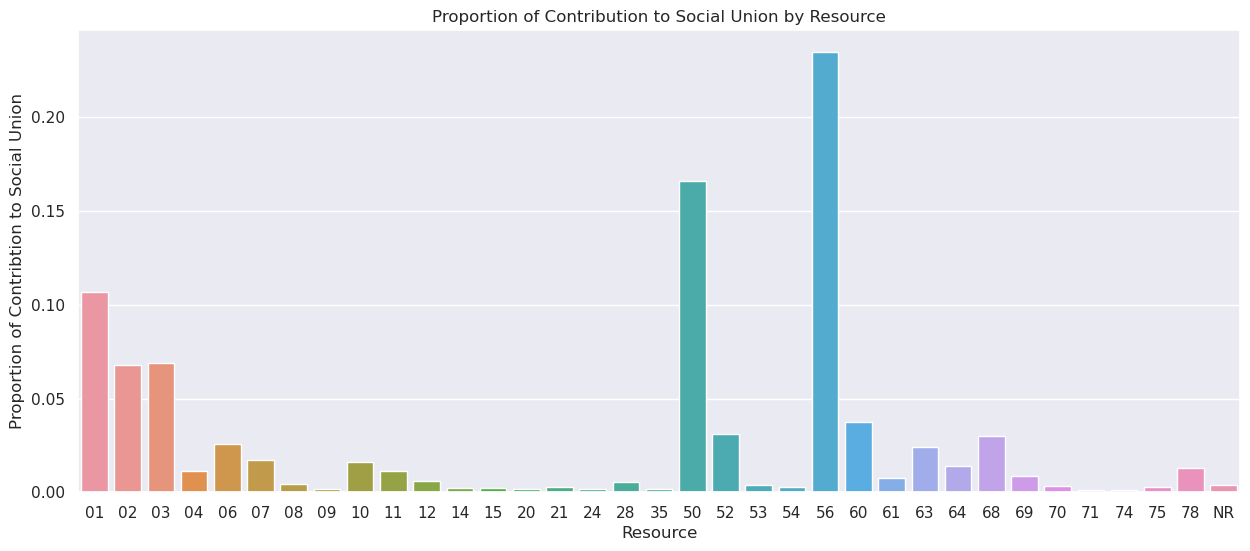

In [ ]:
# CONTRIBUTION TO SOCIAL UNION BY RESOURCE

# By gender
#df_ss_soc_sub= df_ss_soc[df_ss_soc['gender'] == 'm']
# By practice
#df_ss_soc_sub= df_ss_soc[df_ss_soc['fish_pract'] == 'hand_line']
# By ccp
#df_ss_soc_sub= df_ss_soc[df_ss_soc['ccp'] == 'ilha']
# By ccp and practice
#df_ss_soc_sub= df_ss_soc[(df_ss_soc['fish_pract'] == 'glean') & (df_ss_soc['ccp'] == 'ilha')]
#Total
df_ss_soc_sub = df_ss_soc

df_ss_soc_sum= df_ss_soc_sub.groupby(['social_resource']).agg({'social': 'mean'}).reset_index()

sns.barplot(df_ss_soc_sum, x='social_resource', y= 'social')
# set title
plt.title('Proportion of Contribution to Social Union by Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Proportion of Contribtion to Social Union')

# Identity

In [ ]:
parentID_col_vals = list(df_iden['ParentGlobalID'].unique())
resource_col_vals = list(df_iden['identity_resource'].unique())
levels = [parentID_col_vals, resource_col_vals]
new_index = pd.MultiIndex.from_product(levels, names=['ParentGlobalID','identity_resource'])
df_0 = pd.DataFrame(index=new_index, columns=['identity']).fillna(0) 

# drop any pairs that are already in the dataframe
df_iden_index = df_iden.set_index(['ParentGlobalID','identity_resource'])
index_list= (list(df_iden_index.index))
df_0.drop(index_list, axis=0, inplace=True)
df_0.reset_index(inplace=True)
df_0['ObjectID']=[i+1000 for i in range (len(df_0.index))]

# stack the two DataFrames
df_iden_prop = pd.concat([df_iden, df_0], ignore_index=True, axis=0)

# Merge with demo data
df_ss_iden = pd.merge(df_ss_prac,df_iden_prop,on='ParentGlobalID', how='outer')

df_ss_iden.columns

Index(['ParentGlobalID', 'id', 'ccp', 'gender', 'gear_used_hot', 'owner',
       'catch_proportion', 'ObjectID', 'GlobalID', 'identity_resource',
       'identity_raw', 'identity', 'CreationDate', 'Creator', 'EditDate',
       'Editor'],
      dtype='object')

Text(0, 0.5, 'Proportion of Contribution to Identity')

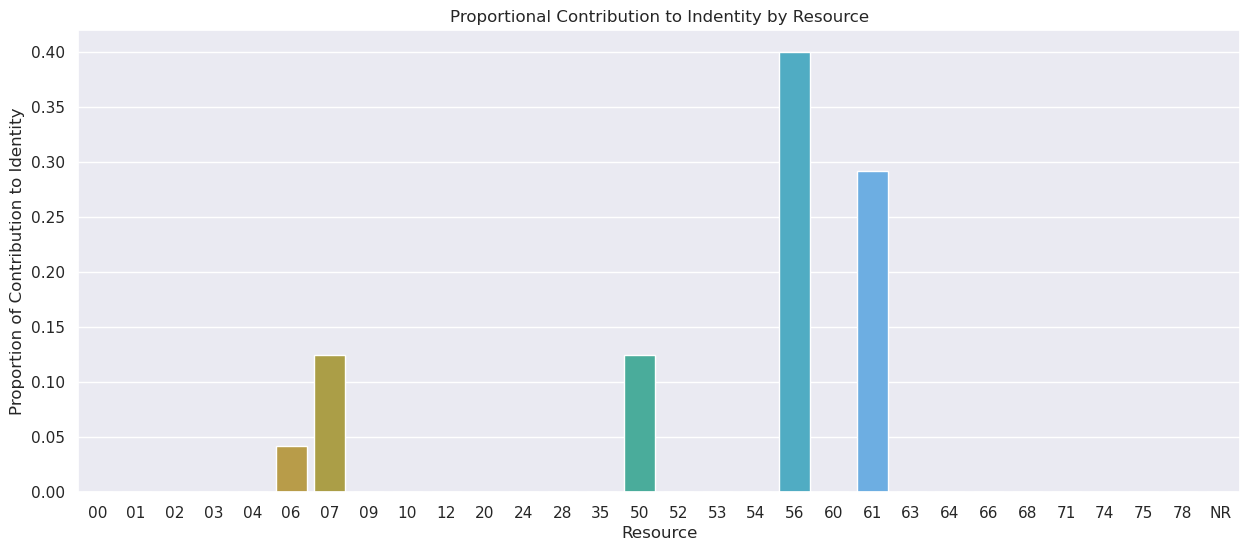

In [ ]:
# CONTRIBUTION TO IDENTITY BY RESOURCE

# By gender
#df_ss_iden_sub= df_ss_iden[df_ss_iden['gender'] == 'm']
# By practice
#df_ss_iden_sub= df_ss_iden[df_ss_iden['fish_pract'] == 'hand_line']
# By ccp
df_ss_iden_sub= df_ss_iden[df_ss_iden['ccp'] == 'ilha']
# By ccp and practice
#df_ss_iden_sub= df_ss_iden[(df_ss_iden['fish_pract'] == 'glean') & (df_ss_iden['ccp'] == 'ilha')]
#Total
#df_ss_iden_sub = df_ss_iden

df_ss_iden_sum= df_ss_iden_sub.groupby(['identity_resource']).agg({'identity': 'mean'}).reset_index()

sns.barplot(df_ss_iden_sum, x='identity_resource', y= 'identity')
# set title
plt.title('Proportional Contribution to Indentity by Resource')
# Set x-axis label
plt.xlabel('Resource')
# Set y-axis label
plt.ylabel('Proportion of Contribution to Identity')